In [173]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import shapiro, anderson
from sklearn.linear_model import LogisticRegression, LinearRegression



# Создаем класс для нейросети

In [88]:
class NeuralNetwork:
    """
    Класс для работы и обучения нейросети.
    
    Параметры:
    ----------
    lr : float, default=0.01
        Рейтинг обучения (learning rate). Определяет шаг изменения весов на каждой итерации.
    
    loss_function : str, default="mae"
        Выбор функции ошибки для обучения. Доступные значения:
        - "mae" - Средняя абсолютная ошибка (Mean Absolute Error).
        - "huber" - Функция ошибки Хьюбера (Huber Loss).
        - "quantile" - Квантильная ошибка (Quantile Loss).
    
    delta : float, default=1.0
        Параметр для функции Хьюбера, определяет границу для переключения между квадратичной и линейной потерей.
    
    quantile : float, default=0.5
        Квантиль для функции ошибки Quantile Loss (значение от 0 до 1).
    
    loss_history : list
        История ошибок на протяжении обучения, используется для построения графика ошибок.
    
    Веса:
    ------
    W1 : ndarray
        Веса для первого слоя.
    
    b1 : ndarray
        Смещения для первого слоя.
    
    W2 : ndarray
        Веса для второго слоя.
    
    b2 : ndarray
        Смещения для второго слоя.
    
    W3 : ndarray
        Веса для третьего слоя.
    
    b3 : ndarray
        Смещения для третьего слоя.
    
    Методы:
    -------
    __init__(self, input_size, hidden_size1, hidden_size2, output_size, lr=0.01, loss_function="mae", delta=1.0, quantile=0.5)
        Конструктор для инициализации нейросети. Устанавливает параметры и случайным образом инициализирует веса и смещения.
    
    relu(self, x)
        Функция активации ReLU.
    
    relu_derivative(self, x)
        Производная функции активации ReLU.
    
    compute_loss(self, y_true, y_pred)
        Вычисляет ошибку на основе выбранной функции ошибки.
    
    forward(self, X)
        Прямой проход (feedforward) через нейросеть.
    
    backward(self, X, y, y_pred)
        Обратное распространение ошибки и обновление весов.
    
    fit(self, X, y, epochs=1000)
        Обучение модели. Метод минимизирует ошибку с использованием градиентного спуска в течение заданного числа эпох.
    
    predict(self, X)
        Предсказание на основе обученной модели.
    
    plot_loss(self)
        Построение графика ошибки в процессе обучения.
    """
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, lr=0.01, loss_function="mae", delta=1.0, quantile=0.5):
        self.lr = lr
        self.loss_function = loss_function  
        self.delta = delta  
        self.quantile = quantile  
        self.loss_history = []  

        # Инициализация весов
        self.W1 = np.random.randn(input_size, hidden_size1) * 0.01
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))

    def relu(self, x: np.ndarray) -> np.ndarray:
        """
        Функция активации ReLU.
        
        Параметры:
        ----------
        x : np.ndarray
            Входные данные (матрица или вектор).

        Возвращает:
        ---------
        np.ndarray
            Результат применения функции ReLU (матрица или вектор).
        """
        return np.maximum(0, x)

    def relu_derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Производная функции активации ReLU.
        
        Параметры:
        ----------
        x : np.ndarray
            Входные данные (матрица или вектор).

        Возвращает:
        ---------
        np.ndarray
            Производная функции ReLU (матрица или вектор).
        """
        return (x > 0).astype(float)

    def compute_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Вычисление ошибки на основе выбранной функции ошибки.
        
        Параметры:
        ----------
        y_true : np.ndarray
            Реальные значения (целевая переменная).

        y_pred : np.ndarray
            Прогнозируемые значения.

        Возвращает:
        ---------
        float
            Значение ошибки.
        """
        error = y_true - y_pred
        if self.loss_function == "mae":
            return np.mean(np.abs(error))
        elif self.loss_function == "huber":
            is_small_error = np.abs(error) <= self.delta
            squared_loss = 0.5 * (error ** 2)
            linear_loss = self.delta * (np.abs(error) - 0.5 * self.delta)
            return np.mean(np.where(is_small_error, squared_loss, linear_loss))
        elif self.loss_function == "quantile":
            return np.mean(np.maximum(self.quantile * error, (self.quantile - 1) * error))
        else:
            raise ValueError("Неизвестная функция ошибки. Используйте 'mae', 'huber' или 'quantile'.")

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Прямой проход (feedforward) через нейросеть.
        
        Параметры:
        ----------
        X : np.ndarray
            Входные данные.

        Возвращает:
        ---------
        np.ndarray
            Прогнозируемые значения (выход нейросети).
        """
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.z3  # Линейный выход
        return self.a3

    def backward(self, X: np.ndarray, y: np.ndarray, y_pred: np.ndarray) -> None:
        """
        Обратное распространение ошибки и обновление весов.
        
        Параметры:
        ----------
        X : np.ndarray
            Входные данные.

        y : np.ndarray
            Реальные значения.

        y_pred : np.ndarray
            Прогнозируемые значения.

        Возвращает:
        ---------
        None
            Метод обновляет веса и смещения нейросети на месте.
        """
        m = X.shape[0]
        error = y_pred - y

        if self.loss_function == "mae":
            dz3 = np.sign(error) / m
        elif self.loss_function == "huber":
            is_small_error = np.abs(error) <= self.delta
            dz3 = np.where(is_small_error, error, self.delta * np.sign(error)) / m
        elif self.loss_function == "quantile":
            dz3 = np.where(error >= 0, self.quantile, self.quantile - 1) / m
        else:
            raise ValueError("Неизвестная функция ошибки.")

        dW3 = np.dot(self.a2.T, dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)
        
        dz2 = np.dot(dz3, self.W3.T) * self.relu_derivative(self.z2)
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(self.z1)
        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000) -> None:
        """
        Обучение нейросети с сохранением истории ошибок.

        Параметры:
        ----------
        X : np.ndarray
            Входные данные.

        y : np.ndarray
            Целевая переменная (реальные значения).

        epochs : int, default=1000
            Количество эпох (итераций) для обучения.

        Возвращает:
        ---------
        None
            Метод обучает нейросеть и сохраняет историю ошибок.
        """
        self.loss_history = []  # Очищаем перед новым обучением

        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y, y_pred)
            self.loss_history.append(loss)  # Сохраняем ошибку

            self.backward(X, y, y_pred)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}: Loss = {loss:.4f}')

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказание на основе обученной модели.

        Параметры:
        ----------
        X : np.ndarray
            Входные данные для предсказания.

        Возвращает:
        ---------
        np.ndarray
            Прогнозируемые значения.
        """
        return self.forward(X)
        
    def plot_loss(self):
        """Функция для построения графика ошибки"""
        plt.plot(range(len(self.loss_history)), self.loss_history, label=f"{self.loss_function.capitalize()} Loss")
        plt.xlabel("Эпохи")
        plt.ylabel("Loss")
        plt.title("График обучения нейросети")
        plt.legend()
        plt.show()


## Загружаем датасет и проверяем его

In [2]:
df = pd.read_csv('content/boston_dataset.csv', sep=r'\s+', header=None, engine='python')

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [61]:
# Удаляем выбросы
mask = df[13] < 50
X_filtered = df.loc[mask].drop(columns=[1, 8, 2, 3, 7, 13])  # Удаляем ненужные столбцы
y_filtered = df.loc[mask, 13]  # Оставляем только цены < 50

In [62]:
# Разделяем данные на train/test после фильтрации
X_train_filtered, X_val_filtered, y_train_filtered, y_val_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

In [63]:
scaler = StandardScaler()
X_train_scaled_filtered = scaler.fit_transform(X_train_filtered)
X_val_scaled_filtered = scaler.transform(X_val_filtered)

In [64]:
y_train_filtered = y_train_filtered.to_numpy().reshape(-1, 1)


In [65]:
# Инициализация модели

In [66]:
input_size = X_train_scaled_filtered.shape[1]  # Количество признаков
hidden_size2 = 64  # Количество нейронов в скрытом слое2
hidden_size = 32  # Количество нейронов в скрытом слое
output_size = 1  # Один выход (предсказание)

model = NeuralNetwork(input_size, hidden_size, hidden_size2, output_size)

In [67]:
# Обучение модели

In [68]:
epochs = 1000
model.fit(X_train_scaled_filtered, y_train_filtered, epochs)

Epoch 0: Loss = 22.0289
Epoch 100: Loss = 21.0234
Epoch 200: Loss = 19.9872
Epoch 300: Loss = 18.7222
Epoch 400: Loss = 15.7853
Epoch 500: Loss = 4.1624
Epoch 600: Loss = 2.8380
Epoch 700: Loss = 2.6286
Epoch 800: Loss = 2.4206
Epoch 900: Loss = 2.2825


In [69]:
y_pred = model.predict(X_val_scaled_filtered)


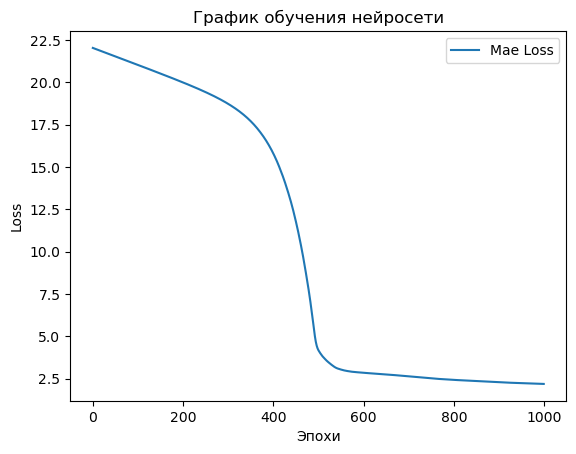

In [70]:
model.plot_loss()

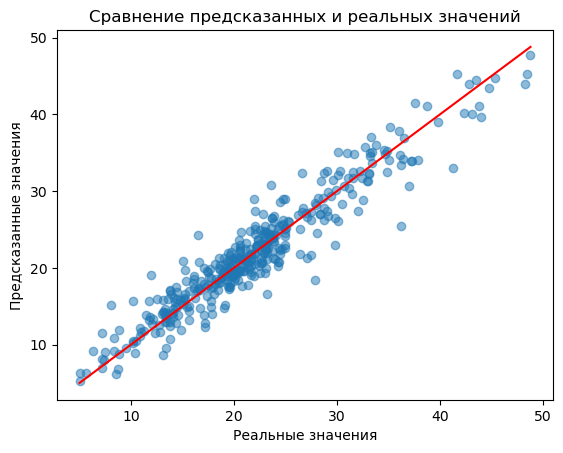

In [26]:
plt.scatter(y_train_filtered, model.predict(X_train_scaled_filtered), alpha=0.5)
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.title("Сравнение предсказанных и реальных значений")
plt.plot([min(y_train_filtered), max(y_train_filtered)], [min(y_train_filtered), max(y_train_filtered)], 'r')  # идеальная линия
plt.show()

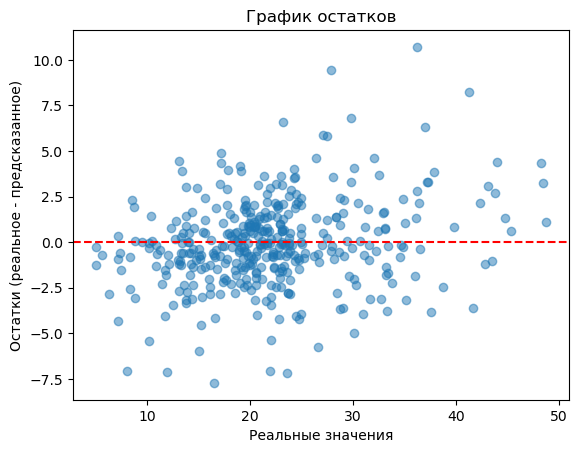

In [27]:
residuals = y_train_filtered - model.predict(X_train_scaled_filtered)
plt.scatter(y_train_filtered, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Реальные значения")
plt.ylabel("Остатки (реальное - предсказанное)")
plt.title("График остатков")
plt.show()

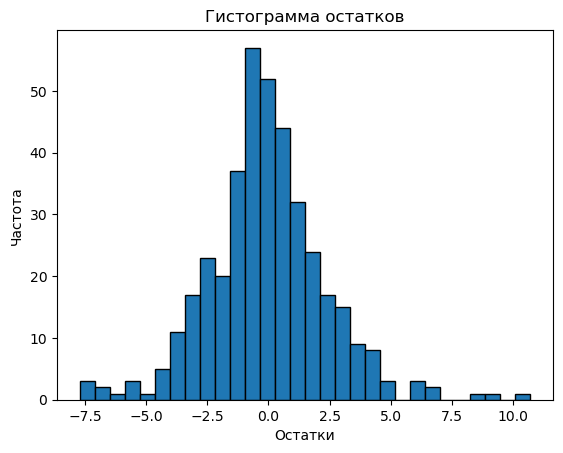

In [28]:
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.title("Гистограмма остатков")
plt.show()

In [71]:
r2 = r2_score(y_train_filtered, model.predict(X_train_scaled_filtered))
print(f"R²-score: {r2:.4f}")

R²-score: 0.8512


In [72]:
residuals = y_train_filtered - model.predict(X_train_scaled_filtered)
stat, p = shapiro(residuals)
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("Распределение остатков похоже на нормальное (p > 0.05)")
else:
    print("Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки")

p-value: 0.0000
Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки


## Попробуем huber в качестве функции ошибки

In [73]:
# Инициализация модели

input_size = X_train_scaled_filtered.shape[1]  # Количество признаков
hidden_size2 = 64  # Количество нейронов в скрытом слое2
hidden_size = 32  # Количество нейронов в скрытом слое
output_size = 1  # Один выход (предсказание)

model_huber = NeuralNetwork(input_size, hidden_size2, hidden_size, output_size, lr=0.01, loss_function="huber")

In [74]:
# Обучение модели
epochs = 1000
model_huber.fit(X_train_scaled_filtered, y_train_filtered, epochs)

Epoch 0: Loss = 21.5289
Epoch 100: Loss = 20.5264
Epoch 200: Loss = 19.5101
Epoch 300: Loss = 18.3904
Epoch 400: Loss = 16.5006
Epoch 500: Loss = 9.0775
Epoch 600: Loss = 2.4125
Epoch 700: Loss = 2.2460
Epoch 800: Loss = 2.1006
Epoch 900: Loss = 1.9178


In [75]:
y_pred = model_huber.predict(X_val_scaled_filtered)

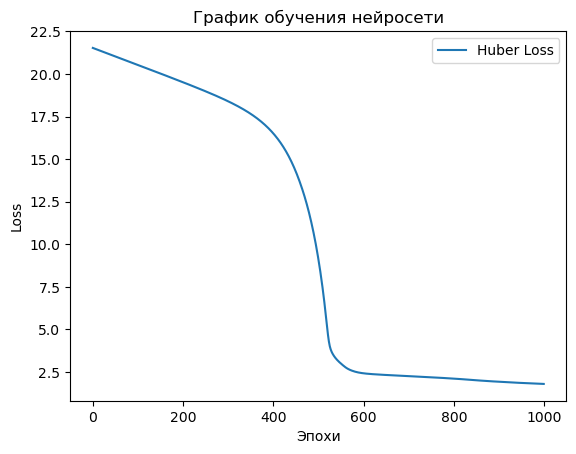

In [76]:
model_huber.plot_loss()

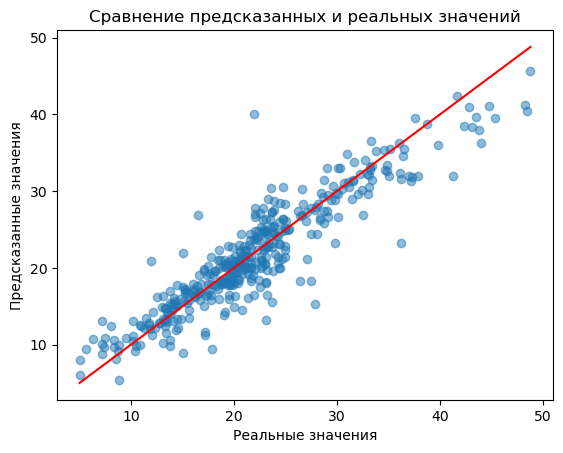

In [77]:
plt.scatter(y_train_filtered, model_huber.predict(X_train_scaled_filtered), alpha=0.5)
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.title("Сравнение предсказанных и реальных значений")
plt.plot([min(y_train_filtered), max(y_train_filtered)], [min(y_train_filtered), max(y_train_filtered)], 'r')  # идеальная линия
plt.show()

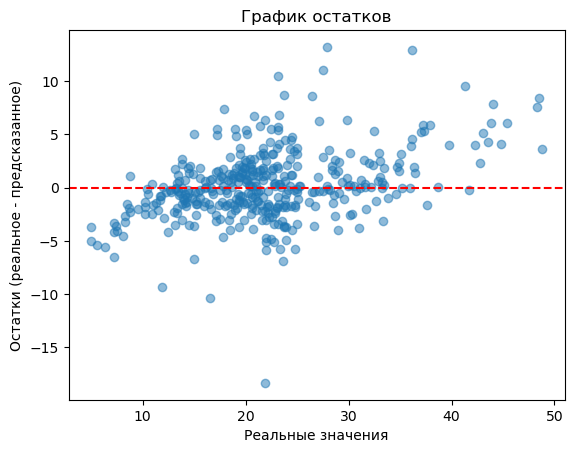

In [56]:
residuals = y_train_filtered - model_huber.predict(X_train_scaled_filtered)
plt.scatter(y_train_filtered, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Реальные значения")
plt.ylabel("Остатки (реальное - предсказанное)")
plt.title("График остатков")
plt.show()

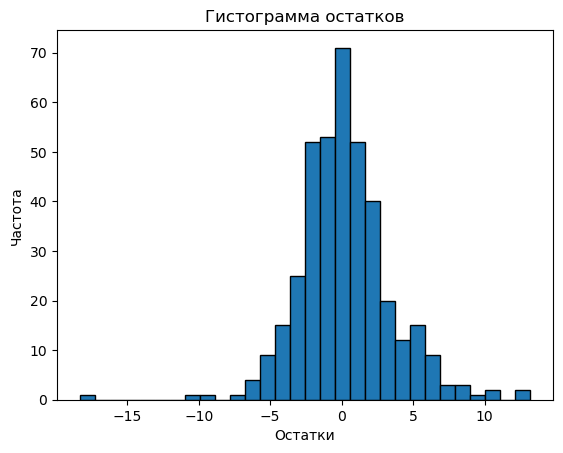

In [57]:
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.title("Гистограмма остатков")
plt.show()

In [80]:
r2 = r2_score(y_train_filtered, model_huber.predict(X_train_scaled_filtered))
print(f"R²-score: {r2:.4f}")

R²-score: 0.8444


In [81]:
residuals = y_train_filtered - model_huber.predict(X_train_scaled_filtered)
stat, p = shapiro(residuals)
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("Распределение остатков похоже на нормальное (p > 0.05)")
else:
    print("Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки")

p-value: 0.0000
Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки


### Выводы: R² = 0.8444 — это хороший показатель, значит, модель объясняет около 84% дисперсии данных. Но раз p-value почти ноль, остатки явно не нормальны, что может указывать на систематические ошибки модели. Но при этом явной формы расперделения на графике остатков не обнаруживается и распределение остатков на гистограмме - почти симметрично

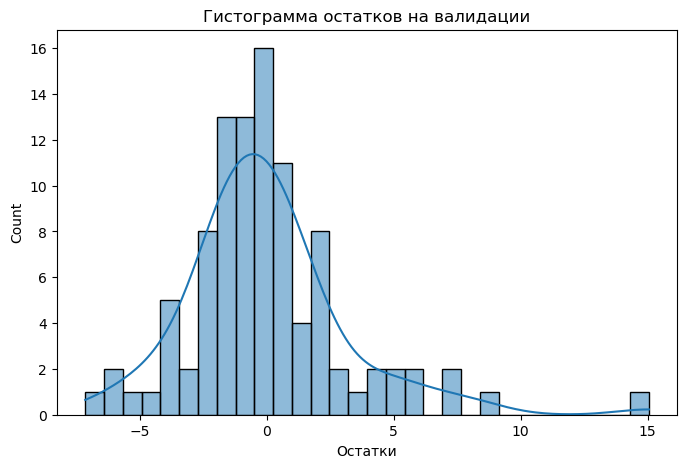

In [85]:
y_pred_val = model_huber.predict(X_val_scaled_filtered).ravel()
residuals_val = y_val_filtered - y_pred_val

plt.figure(figsize=(8, 5))
sns.histplot(residuals_val, bins=30, kde=True)
plt.xlabel("Остатки")
plt.title("Гистограмма остатков на валидации")
plt.show()

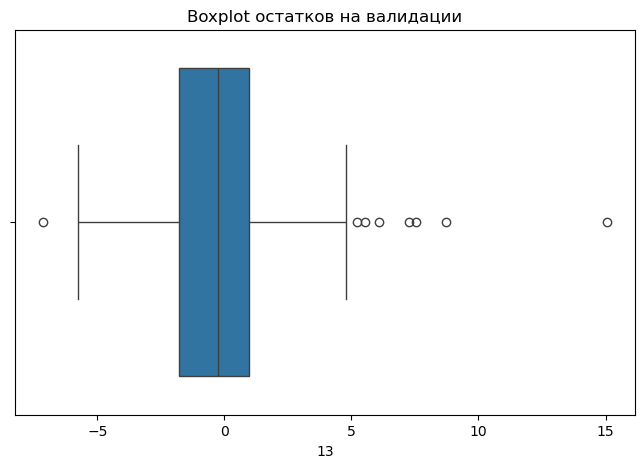

In [86]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=residuals_val)
plt.title("Boxplot остатков на валидации")
plt.show()

In [87]:
print("Минимальный остаток:", residuals_val.min())
print("Максимальный остаток:", residuals_val.max())
print("Среднее значение остатков:", residuals_val.mean())
print("Стандартное отклонение остатков:", residuals_val.std())

Минимальный остаток: -7.140861605275926
Максимальный остаток: 15.045838610537427
Среднее значение остатков: -0.0011062620463516352
Стандартное отклонение остатков: 3.1965984481041056


## Вывод
Среднее ≈ 0 — значит, в целом предсказания модели сбалансированы (нет сильного смещения в одну сторону).
Стандартное отклонение ≈ 3.2 — большая часть остатков лежит в диапазоне [-6.4, 6.4] 
Выбросы > 5 и < -7 — редкие точки, где ошибка предсказания велика.

## Попробуем использовать функцию потерь Quantile Regression Loss

In [90]:
# Инициализация модели

input_size = X_train_scaled_filtered.shape[1]  # Количество признаков
hidden_size2 = 64  # Количество нейронов в скрытом слое2
hidden_size = 32  # Количество нейронов в скрытом слое
output_size = 1  # Один выход (предсказание)

model_quantile = NeuralNetwork(input_size, hidden_size2, hidden_size, output_size, lr=0.01, loss_function="huber")

In [91]:
# Обучение модели
epochs = 1000
model_quantile.fit(X_train_scaled_filtered, y_train_filtered, epochs)

Epoch 0: Loss = 21.5289
Epoch 100: Loss = 20.5254
Epoch 200: Loss = 19.5025
Epoch 300: Loss = 18.3338
Epoch 400: Loss = 16.0754
Epoch 500: Loss = 5.7416
Epoch 600: Loss = 2.3903
Epoch 700: Loss = 2.2474
Epoch 800: Loss = 2.1115
Epoch 900: Loss = 1.9399


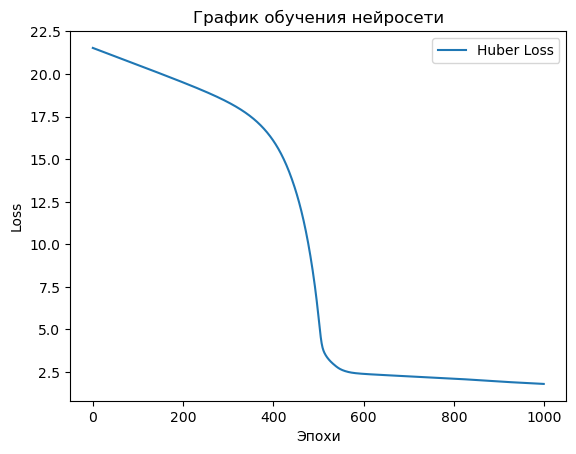

In [92]:
model_quantile.plot_loss()

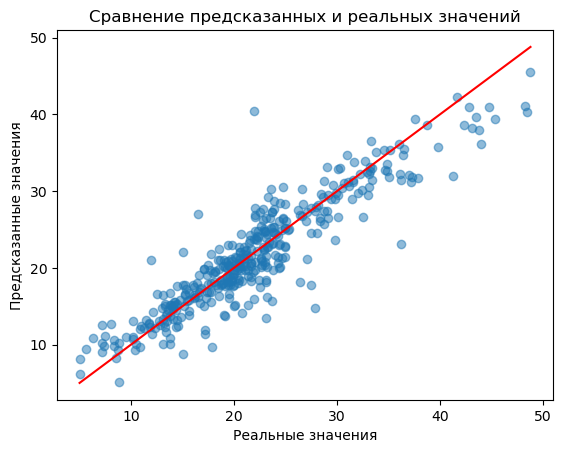

In [93]:
plt.scatter(y_train_filtered, model_quantile.predict(X_train_scaled_filtered), alpha=0.5)
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.title("Сравнение предсказанных и реальных значений")
plt.plot([min(y_train_filtered), max(y_train_filtered)], [min(y_train_filtered), max(y_train_filtered)], 'r')  # идеальная линия
plt.show()

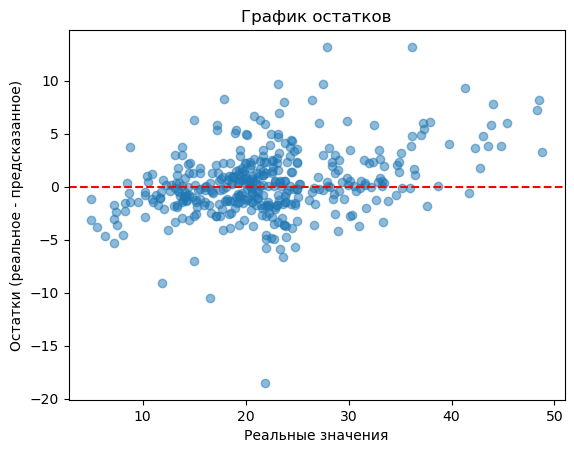

In [94]:
residuals = y_train_filtered - model_quantile.predict(X_train_scaled_filtered)
plt.scatter(y_train_filtered, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Реальные значения")
plt.ylabel("Остатки (реальное - предсказанное)")
plt.title("График остатков")
plt.show()

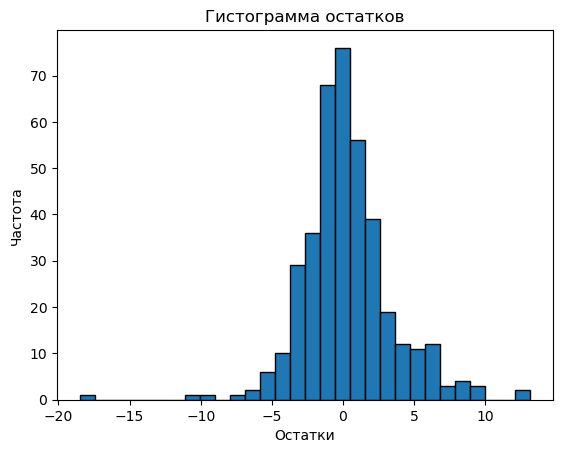

In [95]:
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.title("Гистограмма остатков")
plt.show()

In [96]:
r2 = r2_score(y_train_filtered, model_quantile.predict(X_train_scaled_filtered))
print(f"R²-score: {r2:.4f}")

R²-score: 0.8414


In [97]:
residuals = y_train_filtered - model_quantile.predict(X_train_scaled_filtered)
stat, p = shapiro(residuals)
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("Распределение остатков похоже на нормальное (p > 0.05)")
else:
    print("Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки")

p-value: 0.0000
Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки


## Попробуем почистить данные на выбросы

In [135]:
# Функция для удаления выбросов с использованием IQR
def remove_outliers_IQR(df, numerical_columns):
    initial_shape = df.shape[0]  # Количество строк до очистки
    total_removed = 0  # Счётчик удалённых строк
    
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)  # Первый квартиль
        Q3 = df[col].quantile(0.75)  # Третий квартиль
        IQR = Q3 - Q1  # Межквартильный размах
        lower_bound = Q1 - 1.5 * IQR  # Нижняя граница
        upper_bound = Q3 + 1.5 * IQR  # Верхняя граница
        
        before = df.shape[0]  # Количество строк до фильтрации по колонке
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]  
        removed = before - df.shape[0]  # Разница строк до и после
        total_removed += removed
        
        print(f"Колонка '{col}': удалено {removed} строк")

    final_shape = df.shape[0]  # Количество строк после очистки
    print(f"\nВсего удалено {total_removed} строк из {initial_shape} ({(total_removed / initial_shape) * 100:.2f}%)")
    
    return df

In [136]:
numerical_columns = df.select_dtypes(include=['number']).columns


In [137]:
df_cleaned = remove_outliers_IQR(df, numerical_columns)

# Удаляем выбросы
mask = df_cleaned[13] < 50
X_filtered = df_cleaned.loc[mask].drop(columns=[1, 8, 2, 3, 7, 13])  # Удаляем ненужные столбцы
y_filtered = df_cleaned.loc[mask, 13]  # Оставляем только цены < 50

Колонка '0': удалено 66 строк
Колонка '1': удалено 45 строк
Колонка '2': удалено 0 строк
Колонка '3': удалено 34 строк
Колонка '4': удалено 12 строк
Колонка '5': удалено 21 строк
Колонка '6': удалено 0 строк
Колонка '7': удалено 0 строк
Колонка '8': удалено 55 строк
Колонка '9': удалено 5 строк
Колонка '10': удалено 8 строк
Колонка '11': удалено 25 строк
Колонка '12': удалено 5 строк
Колонка '13': удалено 16 строк

Всего удалено 292 строк из 506 (57.71%)


In [138]:
# Разделяем данные на train/test после фильтрации
X_train_filtered_clean, X_val_filtered_clean, y_train_filtered_clean, y_val_filtered_clean = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

In [139]:
scaler = StandardScaler()
X_train_scaled_filtered_clean = scaler.fit_transform(X_train_filtered_clean)
X_val_scaled_filtered_clean = scaler.transform(X_val_filtered_clean)

In [140]:
y_train_filtered_clean = y_train_filtered_clean.to_numpy().reshape(-1, 1)

In [141]:
# Инициализация модели
input_size = X_train_scaled_filtered_clean.shape[1]  # Количество признаков
hidden_size2 = 64  # Количество нейронов в скрытом слое2
hidden_size = 32  # Количество нейронов в скрытом слое
output_size = 1  # Один выход (предсказание)

model_quantile_clean = NeuralNetwork(input_size, hidden_size, hidden_size2, output_size)

In [142]:
# Обучение модели
epochs = 1000
model_quantile_clean.fit(X_train_scaled_filtered_clean, y_train_filtered_clean, epochs)

Epoch 0: Loss = 22.2747
Epoch 100: Loss = 21.2676
Epoch 200: Loss = 20.2203
Epoch 300: Loss = 18.8706
Epoch 400: Loss = 15.2089
Epoch 500: Loss = 2.0008
Epoch 600: Loss = 1.7477
Epoch 700: Loss = 1.6955
Epoch 800: Loss = 1.6712
Epoch 900: Loss = 1.6579


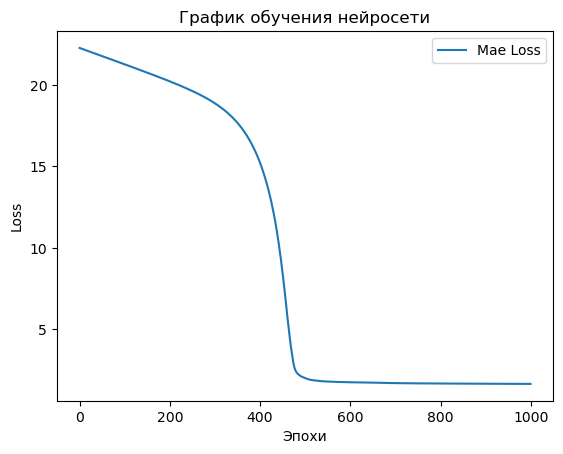

In [143]:
model_quantile_clean.plot_loss()

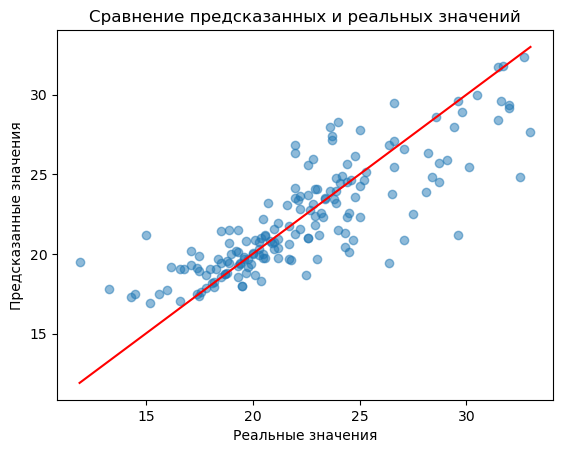

In [144]:
plt.scatter(y_train_filtered_clean, model_quantile_clean.predict(X_train_scaled_filtered_clean), alpha=0.5)
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.title("Сравнение предсказанных и реальных значений")
plt.plot([min(y_train_filtered_clean), max(y_train_filtered_clean)], [min(y_train_filtered_clean), max(y_train_filtered_clean)], 'r')  # идеальная линия
plt.show()

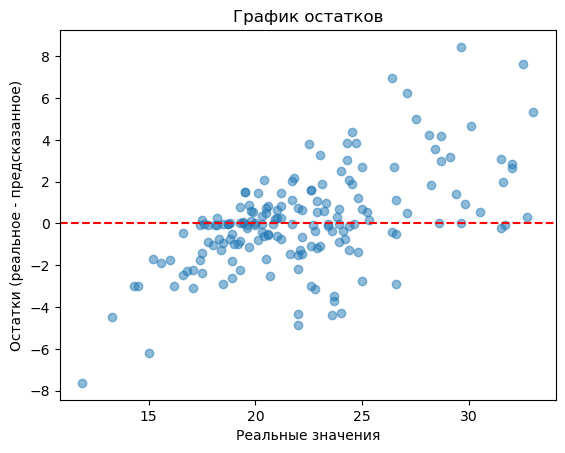

In [145]:
residuals = y_train_filtered_clean - model_quantile_clean.predict(X_train_scaled_filtered_clean)
plt.scatter(y_train_filtered_clean, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Реальные значения")
plt.ylabel("Остатки (реальное - предсказанное)")
plt.title("График остатков")
plt.show()

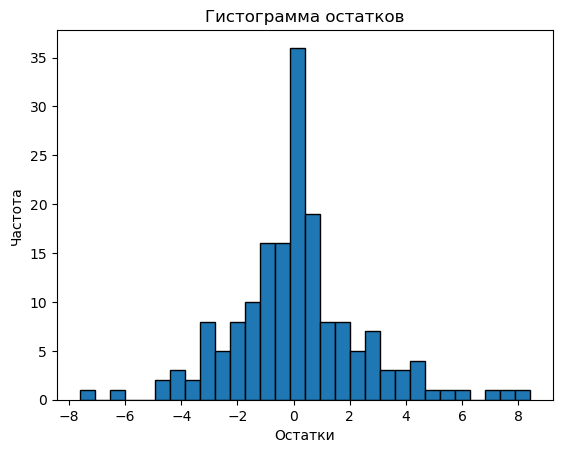

In [146]:
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.title("Гистограмма остатков")
plt.show()

In [147]:
r2 = r2_score(y_train_filtered_clean, model_quantile_clean.predict(X_train_scaled_filtered_clean))
print(f"R²-score: {r2:.4f}")

R²-score: 0.6935


In [148]:
residuals = y_train_filtered_clean - model_quantile_clean.predict(X_train_scaled_filtered_clean)
stat, p = shapiro(residuals)
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("Распределение остатков похоже на нормальное (p > 0.05)")
else:
    print("Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки")

p-value: 0.0002
Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки


## Попробуем Стэкинг

In [164]:
# Получаем предсказания для валидационных данных
y_pred_quantile = model_quantile.predict(X_val_filtered)
y_pred = model.predict(X_val_filtered)
y_pred_huber = model_huber.predict(X_val_filtered)

# Конкатенируем предсказания как новые признаки
X_meta = np.concatenate([y_pred_huber, y_pred, y_pred_quantile], axis=1)

# Обучаем метамодель
meta_model = LinearRegression()
meta_model.fit(X_meta, y_val_filtered)  # Обучаем на валидационных данных

# Предсказания метамодели
final_predictions_meta = meta_model.predict(X_meta)  # Получаем предсказания для валидации

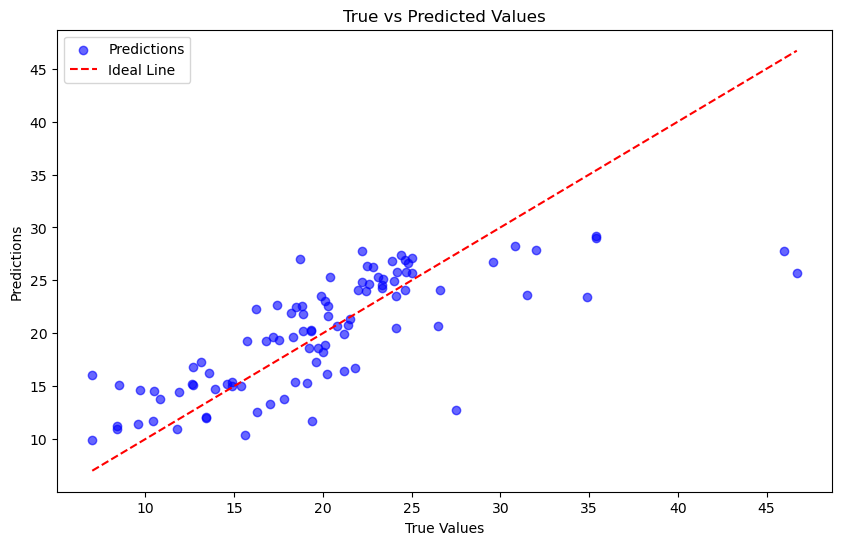

In [165]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val_filtered, final_predictions_meta, color='blue', alpha=0.6, label='Predictions')
plt.plot([min(y_val_filtered), max(y_val_filtered)], [min(y_val_filtered), max(y_val_filtered)], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()


### Данные немного прижимаются к идеальной прямо предсказаний, но есть и сильные выбросы, что указывает на то, что модель иногда дает слишком высокие или низкие предсказания. Это может быть связано с переобучением или недостаточной способностью модели справляться с вариациями данных.

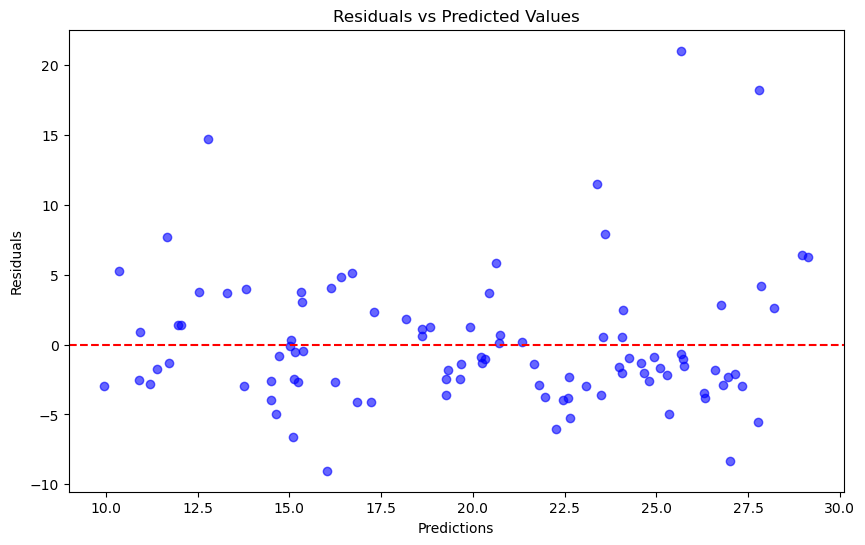

In [166]:
residuals = y_val_filtered - final_predictions_meta

plt.figure(figsize=(10, 6))
plt.scatter(final_predictions_meta, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

### Ярковыраженной структуры распеределение точек остатков не имеет, что может указывать на то, что модель не упустила какие-то нелинейные зависимости в данных. 

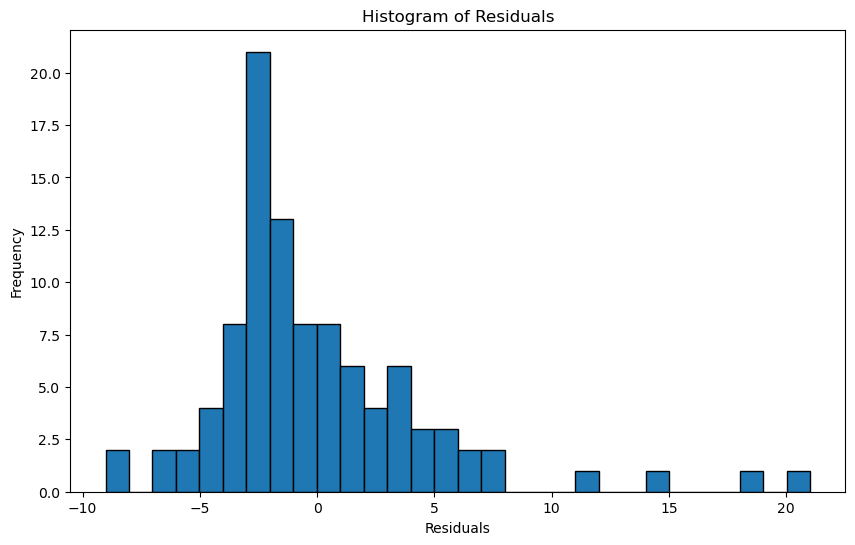

In [167]:
# Гистограмма остатков
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Распередление на гистограмме немного смещенно влево к значению -2 но в остальном симметрично, что может указывать на слабую ошибку предсказания для некоторых значений. Это также может быть связано с сильными выбросами или наклонностью модели к недооценке значений.

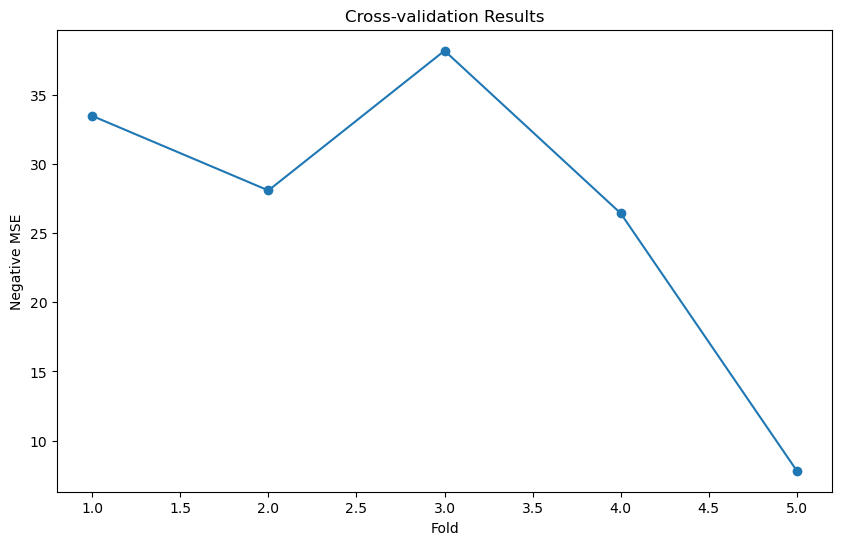

In [169]:
# Кросс-валидация
cv_scores = cross_val_score(meta_model, X_meta, y_val_filtered, cv=5, scoring='neg_mean_squared_error')

# График результатов кросс-валидации
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores) + 1), -cv_scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('Negative MSE')
plt.title('Cross-validation Results')
plt.show()

### Поведение MSE в процессе кросс-валидации (снижение до Fold=2, рост до Fold=3 и падение до почти нуля на Fold=5) может указывать на несколько вещей:

Возможно, модели лучше справляются с определенными подмножествами данных (например, на Fold=5), и поэтому производят меньшие ошибки на этих подмножествах.
Повышение ошибки на Fold=3 может быть связано с переобучением на определенной части данных.

In [170]:
mse = mean_squared_error(y_val_filtered, final_predictions_meta)
mae = mean_absolute_error(y_val_filtered, final_predictions_meta)
r2 = r2_score(y_val_filtered, final_predictions_meta)

# Таблица метрик
metrics = {'MSE': mse, 'MAE': mae, 'R²': r2}
print(f"Model Metrics:\n{metrics}")

Model Metrics:
{'MSE': 22.944983849067782, 'MAE': 3.4132379541822098, 'R²': 0.5508500844008293}


### Вывод:
MSE (Mean Squared Error): 22.94 — это средняя квадратичная ошибка, которая говорит о средней величине ошибки на каждом предсказании.
MAE (Mean Absolute Error): 3.41 — это средняя абсолютная ошибка, которая дает представление о том, на сколько в среднем модель ошибается в абсолютных величинах.
R² (Коэффициент детерминации): 0.55 — это довольно хороший результат для регрессионных задач, который указывает, что модель объясняет 55% вариации данных. Но моожно улучшить.

<Figure size 1000x600 with 0 Axes>

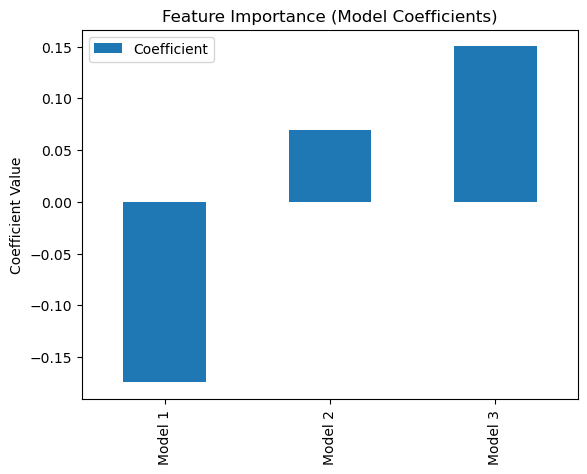

In [171]:

coefficients = meta_model.coef_
feature_importance = pd.DataFrame(coefficients, columns=['Coefficient'], index=['Model 1', 'Model 2', 'Model 3'])  # для каждой модели в ансамбле

# График важности признаков
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Model Coefficients)')
plt.ylabel('Coefficient Value')
plt.show()

###  Model3 имеет коэффициенты от 0 до 15, а Model1 от 0 до -15, это может говорить о том, что признаки, связанные с Model3, имеют наибольшее влияние на предсказания, в то время как признаки, связанные с Model1, имеют отрицательное влияние. 

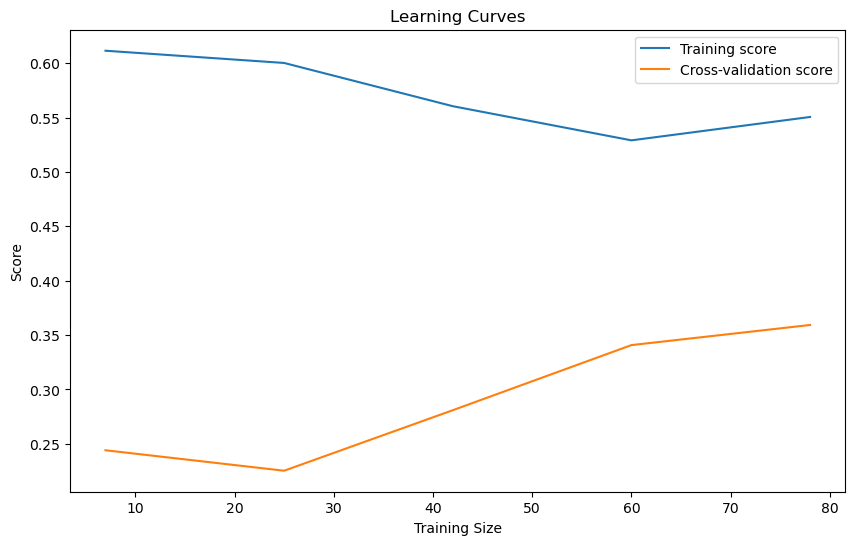

In [174]:
train_sizes, train_scores, test_scores = learning_curve(meta_model, X_meta, y_val_filtered, cv=5)

# График кривых обучения
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

### На графике кривых обучения Training score располагается выше и снижается от 0,61 до 0,55 , а Cross-validation score  располагается ниже и повышается от 0.25 до 0,35
Поведение кривых обучения ( Training score выше, а Cross-validation score ниже) говорит о том, что модель склонна к переобучению. Это типичное явление, когда модель находит закономерности в обучающих данных, но не может обобщить их на тестовых данных.